# Tensor image convolution

In [63]:
import torch
from torch import nn
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt

%matplotlib inline

In [64]:
frame = torch.load('../data/processed/pnf/2017/15min/tensors/2017-01-01_03;30;00-2017-01-01_03;45;00--2017-01-01_00;00;00-2017-01-02_00;00;00--p0-14.pkl')

frame.shape
frame = frame.reshape(-1, 3)
frame.shape

torch.Size([4761, 3])

In [65]:
frame.view([1, -1]).shape

torch.Size([1, 14283])

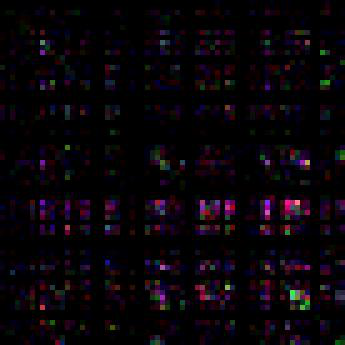

In [66]:
from PIL import Image

fviz = Image.open('../data/processed/pnf/2017/15min/viz_images/2017-07-06_18;30;00-2017-07-06_18;45;00--2017-07-03_00;00;00-2017-07-10_00;00;00--p27-362.jpg')
fviz

In [67]:
def get_channel(image, layer:str):
    '''
    Get a layer of the snapshot.
    Params:
        image: PIL image
        channel: one of R-F,G-P,B-N
    Return:
        single channel image
    '''
    assert layer in ['P', 'N', 'F']
    namedict = {'P': 'G', 'N': 'B', 'F': 'R'}
    chandict = {'R':0, 'G':1, 'B':2}
    template = np.array(image)
    chan = np.zeros([*template.shape], dtype='uint8')
    chan[:,:,chandict[namedict[layer]]] = image.getchannel(namedict[layer])
    chan = Image.fromarray(chan)
    return chan

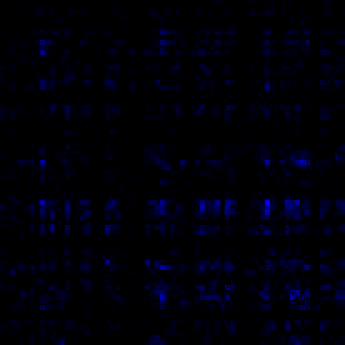

In [68]:
get_channel(fviz, 'N')
# fviz.getchannel('B')

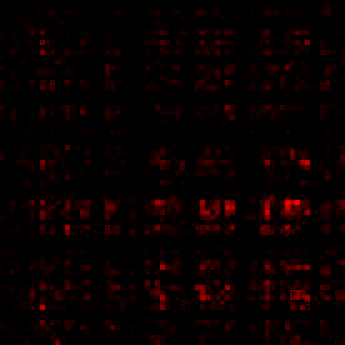

In [69]:
get_channel(fviz, 'F')
# fviz.getchannel('R')

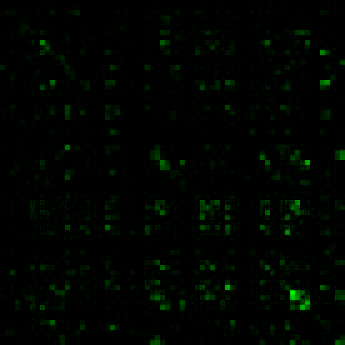

In [70]:
get_channel(fviz, 'P')
# fviz.getchannel('G')

In [71]:
conv1 = torch.nn.Conv2d(3, 33, 5, 2)
conv2 = torch.nn.Conv2d(33, 64, 3, 2)

conv1 = torch.nn.Conv2d(3, 16, 9, stride=2)
conv2 = torch.nn.Conv2d(16, 4, 3, stride=2)

frame = frame.view([1, 3, 69, 69])#.type(torch.DoubleTensor)
frame = frame.double()
frame.requires_grad

False

In [72]:
conv1.weight = torch.nn.Parameter(conv1.weight.double(), requires_grad=False)
conv1.bias = torch.nn.Parameter(conv1.bias.double(), requires_grad=False)
conv2.weight = torch.nn.Parameter(conv2.weight.double(), requires_grad=False)
conv2.bias = torch.nn.Parameter(conv2.bias.double(), requires_grad=False)

In [73]:
out = conv1(frame)
last = conv2(out)

In [74]:
out.shape

torch.Size([1, 16, 31, 31])

In [75]:
last.shape

torch.Size([1, 4, 15, 15])

In [76]:
# temp = out[:,:3,:,:].detach().numpy().reshape([33,33,3]).astype('int8')
temp = out.view((16,31,31))
temp = temp.permute(2,1,0)
temp.shape

torch.Size([31, 31, 16])

In [77]:
last = last.view((4, 15, 15))
last = last.permute(2,1,0)

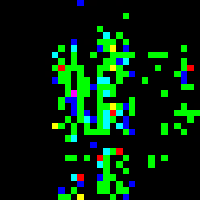

In [78]:
Image.fromarray(temp.numpy()[:,:,:3].astype('uint8')).resize((200,200))

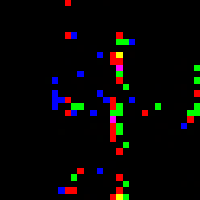

In [79]:
Image.fromarray(temp.numpy()[:,:,3:6].astype('uint8')).resize((200,200))

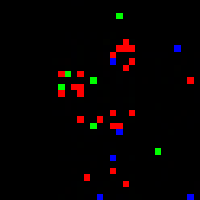

In [80]:
Image.fromarray(temp.numpy()[:,:,6:9].astype('uint8')).resize((200,200))

In [81]:
Image.fromarray(temp.numpy()[:,:,9:12].astype('uint8'))

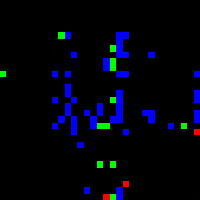

In [82]:
Image.fromarray(temp.numpy()[:,:,12:15].astype('uint8')).resize((200,200))

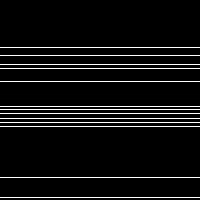

In [83]:
Image.fromarray(temp.numpy()[:,:,15:16].astype('uint8').reshape((-1, 1)), mode='L').resize((200,200))

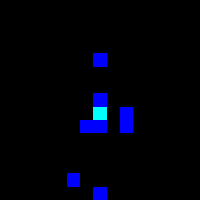

In [84]:
Image.fromarray(last.numpy()[:,:,0:3].astype('uint8')).resize((200,200))

In [85]:
class ConvAutoEncoderShallow(nn.Module):
    '''
    A CNN autoencoder model, without any preprocessing to the inputs.
    '''

    def __init__(self, output_size, mode='pnf', batch_norm=False):
        '''
        Auto encoder initialization.

        Args:
            input_size:     dimention of state vector
            output_size:    the same shape of input_size
            mode:           either `od`(greyscale) or `pnf`(rgb)
            train_on_gpu:   whether use GPU or not
            device:         where to put the model
        '''
        super(ConvAutoEncoderShallow, self).__init__()
        self.is_conv = True
        self.output_size = output_size
        self.chan = 3
        self.batch_norm = batch_norm
        if mode == 'od':
            self.chan = 1
        elif mode == 'pnf':
            self.chan = 3
        # define encode and decode layers
        self.conv1 = nn.Conv2d(self.chan, 16, 9, stride=2)
        self.conv2 = nn.Conv2d(16, 4, 3, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(4, 16, 3, stride=2)
        self.t_conv1 = nn.ConvTranspose2d(16, self.chan, 9, stride=2)

    def forward(self, x):
        '''
        Pass tensor into the encoder and get it out from the decoder.

        Args:
            x:      input state vector (flattened)
        Returns:
            out:    output of current time step
        '''
        batch_size = x.size(0)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.t_conv2(x))
        out = self.t_conv1(x)

        # reshape to be batch_size first
        out = out.view(batch_size, self.chan, 69, 69)

        return out

In [86]:
model = ConvAutoEncoderShallow(69*69*3)

In [87]:
print(model)

ConvAutoEncoderShallow(
  (conv1): Conv2d(3, 16, kernel_size=(9, 9), stride=(2, 2))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(4, 16, kernel_size=(3, 3), stride=(2, 2))
  (t_conv1): ConvTranspose2d(16, 3, kernel_size=(9, 9), stride=(2, 2))
)


In [88]:
model.conv1

Conv2d(3, 16, kernel_size=(9, 9), stride=(2, 2))